In [1]:
import os
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from datetime import datetime

# Lấy đường dẫn tuyệt đối của thư mục cha
CURRENT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
print(f"Thư mục hiện tại: {CURRENT_DIR}")

# Danh sách từ ghép cần giữ nguyên
FRUIT_NAMES = [
    "hạnh nhân", "mãng cầu xiêm", "táo", "mơ", "mít", "bơ", "chuối",
    "dâu rừng", "cam bergamot", "lý chua đen", "nho đen", "cam đỏ",
    "việt quất", "sa kê", "chà là sấy", "khế", "hạt điều", "anh đào",
    "cà chua bi", "hạt dẻ", "cam quýt", "dừa", "lê vương miện",
    "lê đường sơn", "cam dekopon", "thị", "sầu riêng", "sung", "đào",
    "quả thanh trà", "nhân sâm", "dưa vàng", "nho", "nho trắng",
    "bưởi chùm", "táo xanh", "ổi", "dưa hami", "táo gai", "hạt phỉ",
    "hồ đào", "dưa mật", "lê housi", "đào mọng", "táo tàu", "kiwi",
    "quất", "chanh vàng", "chanh xanh", "vải", "nhãn", "tỳ bà",
    "hạt mắc ca", "quýt", "xoài", "măng cụt", "dâu tằm", "dưa lưới",
    "hồng xiêm", "cam rốn", "xuân đào", "ô liu", "đu đủ", "chanh dây",
    "hạt pecan", "hồng", "dứa", "hạt dẻ cười", "thanh long", "mận",
    "táo chua", "lựu", "bưởi", "quýt ponkan", "mận khô", "chôm chôm",
    "phúc bồn tử", "nho đỏ", "da rắn", "lê cát", "mía", "cam đường",
    "mãng cầu", "cam ba lá", "hạt óc chó", "hồng bì", "mận đá",
    "hồng táo", "củ sắn"
]

# Các thông số
IMG_SIZE = 224
BATCH_SIZE = 32
MIN_WORD_FREQ = 2

# Đường dẫn
DATA_DIR = os.path.join(CURRENT_DIR, "raw")
PROCESSED_DIR = os.path.join(CURRENT_DIR, "processed_data")
JSON_PATH = os.path.join(DATA_DIR, "vqa_data.json")

# Tạo thư mục processed_data nếu chưa tồn tại
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(os.path.join(PROCESSED_DIR, "images"), exist_ok=True)
os.makedirs(os.path.join(PROCESSED_DIR, "text"), exist_ok=True)

# Transform cho ảnh
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

c:\Users\NGUYEN\miniconda3\envs\py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Thư mục hiện tại: c:\Users\NGUYEN\Desktop\VQA-Vegetable-Fruits


In [2]:
class TextProcessor:
    def __init__(self):
        self.fruit_names = set(FRUIT_NAMES)
        self.special_tokens = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"]
        self.token_to_idx = {token: idx for idx, token in enumerate(self.special_tokens)}
        self.idx_to_token = {idx: token for idx, token in enumerate(self.special_tokens)}
        self.next_idx = len(self.special_tokens)

    def normalize_text(self, text):
        # Chuyển về chữ thường
        text = text.lower()
        
        # Chuẩn hóa dấu cách
        text = re.sub(r'\s+', ' ', text)
        
        # Chuẩn hóa dấu câu
        text = re.sub(r'[.,!?;:]', ' ', text)
        
        # Loại bỏ khoảng trắng đầu và cuối
        text = text.strip()
        
        return text

    def tokenize(self, text):
        text = self.normalize_text(text)
        
        # Tìm các từ ghép trước
        tokens = []
        words = text.split()
        i = 0
        while i < len(words):
            found_compound = False
            for fruit in self.fruit_names:
                if ' '.join(words[i:i+len(fruit.split())]) == fruit:
                    tokens.append(fruit)
                    i += len(fruit.split())
                    found_compound = True
                    break
            if not found_compound:
                tokens.append(words[i])
                i += 1
        
        return tokens

    def build_vocabulary(self, texts, min_freq=2):
        # Đếm tần suất từ
        word_freq = Counter()
        for text in texts:
            tokens = self.tokenize(text)
            word_freq.update(tokens)
        
        # Thêm các từ có tần suất >= min_freq vào vocabulary
        for word, freq in word_freq.items():
            if freq >= min_freq and word not in self.token_to_idx:
                self.token_to_idx[word] = self.next_idx
                self.idx_to_token[self.next_idx] = word
                self.next_idx += 1

    def encode(self, text):
        tokens = self.tokenize(text)
        return [self.token_to_idx.get(token, self.token_to_idx["<UNK>"]) for token in tokens]

    def decode(self, indices):
        return [self.idx_to_token.get(idx, "<UNK>") for idx in indices]

    def __len__(self):
        return len(self.token_to_idx)

In [3]:
def process_image(image_path, transform):
    try:
        image = Image.open(image_path).convert('RGB')
        if transform:
            image = transform(image)
        return image
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {image_path}: {str(e)}")
        return None

def create_dataset(data, text_processor, transform, is_train=True):
    images = []
    questions = []
    answers = []
    
    # Tính max length cho padding
    max_question_length = 0
    max_answer_length = 0
    
    for item in data:
        for qa in item['questions']:
            question = qa['question']
            answer = qa['correct_answer']
            
            # Encode câu hỏi và câu trả lời
            question_indices = text_processor.encode(question)
            answer_indices = text_processor.encode(answer)
            
            # Thêm special tokens
            question_indices = [text_processor.token_to_idx["<SOS>"]] + question_indices + [text_processor.token_to_idx["<EOS>"]]
            answer_indices = [text_processor.token_to_idx["<SOS>"]] + answer_indices + [text_processor.token_to_idx["<EOS>"]]
            
            max_question_length = max(max_question_length, len(question_indices))
            max_answer_length = max(max_answer_length, len(answer_indices))
    
    # Padding function
    def pad_sequence(sequence, max_length):
        if len(sequence) > max_length:
            return sequence[:max_length]
        return sequence + [text_processor.token_to_idx["<PAD>"]] * (max_length - len(sequence))
    
    # Xử lý dữ liệu
    for item in tqdm(data, desc="Xử lý dữ liệu"):
        img_path = os.path.join(DATA_DIR, item['image_id'])
        image = process_image(img_path, transform)
        
        if image is None:
            continue
            
        images.append(image)
        
        item_questions = []
        item_answers = []
        
        for qa in item['questions']:
            question = qa['question']
            answer = qa['correct_answer']
            
            # Encode câu hỏi và câu trả lời
            question_indices = text_processor.encode(question)
            answer_indices = text_processor.encode(answer)
            
            # Thêm special tokens
            question_indices = [text_processor.token_to_idx["<SOS>"]] + question_indices + [text_processor.token_to_idx["<EOS>"]]
            answer_indices = [text_processor.token_to_idx["<SOS>"]] + answer_indices + [text_processor.token_to_idx["<EOS>"]]
            
            # Padding
            question_indices = pad_sequence(question_indices, max_question_length)
            answer_indices = pad_sequence(answer_indices, max_answer_length)
            
            item_questions.append(question_indices)
            item_answers.append(answer_indices)
        
        questions.append(item_questions)
        answers.append(item_answers)
    
    return {
        'images': torch.stack(images),
        'questions': torch.tensor(questions),
        'answers': torch.tensor(answers)
    }

In [4]:
# Load dữ liệu
with open(JSON_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Khởi tạo text processor
text_processor = TextProcessor()

# Chuẩn bị dữ liệu cho vocabulary
questions = [qa['question'] for item in data for qa in item['questions']]
answers = [qa['correct_answer'] for item in data for qa in item['questions']]

# Build vocabulary
text_processor.build_vocabulary(questions + answers, min_freq=MIN_WORD_FREQ)

# Phân loại dữ liệu theo thư mục
fruit_dirs = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
print(f"Tổng số thư mục trái cây: {len(fruit_dirs)}")

# Khởi tạo các list để lưu dữ liệu
train_data = []
val_data = []
test_data = []

# Chia dữ liệu theo tỷ lệ 8:1:1 cho mỗi thư mục
np.random.seed(42)  # Để đảm bảo kết quả nhất quán

for fruit_dir in fruit_dirs:
    # Lọc dữ liệu cho thư mục hiện tại
    dir_data = [item for item in data if item['image_id'].startswith(fruit_dir)]
    np.random.shuffle(dir_data)
    
    # Tính số lượng cho mỗi tập
    total = len(dir_data)
    train_size = int(0.8 * total)
    val_size = int(0.1 * total)
    
    # Chia dữ liệu
    train_data.extend(dir_data[:train_size])
    val_data.extend(dir_data[train_size:train_size + val_size])
    test_data.extend(dir_data[train_size + val_size:])

# Xử lý và lưu dữ liệu
for split_name, split_data, transform in [
    ('train', train_data, train_transform),
    ('val', val_data, val_transform),
    ('test', test_data, val_transform)
]:
    print(f"\nXử lý {split_name} set...")
    dataset = create_dataset(split_data, text_processor, transform, is_train=(split_name == 'train'))
    
    # Lưu ảnh
    np.savez_compressed(
        os.path.join(PROCESSED_DIR, 'images', f'{split_name}.npz'),
        images=dataset['images'].numpy()
    )
    
    # Lưu text
    np.savez_compressed(
        os.path.join(PROCESSED_DIR, 'text', f'{split_name}_questions.npz'),
        questions=dataset['questions'].numpy()
    )
    np.savez_compressed(
        os.path.join(PROCESSED_DIR, 'text', f'{split_name}_answers.npz'),
        answers=dataset['answers'].numpy()
    )

Tổng số thư mục trái cây: 92

Xử lý train set...


Xử lý dữ liệu: 100%|██████████| 7284/7284 [00:38<00:00, 189.05it/s]



Xử lý val set...


Xử lý dữ liệu: 100%|██████████| 874/874 [00:03<00:00, 281.08it/s]



Xử lý test set...


Xử lý dữ liệu: 100%|██████████| 993/993 [00:03<00:00, 273.63it/s]



Thống kê dữ liệu theo thư mục:
Tổng số ảnh: 8579
Tổng số câu hỏi: 34316
Kích thước vocabulary: 229

Phân bố theo thư mục:

almond:
- Tổng số: 66
- Train: 52 (78.8%)
- Val: 6 (9.1%)
- Test: 8 (12.1%)

annona_muricata:
- Tổng số: 120
- Train: 96 (80.0%)
- Val: 12 (10.0%)
- Test: 12 (10.0%)

apple:
- Tổng số: 153
- Train: 122 (79.7%)
- Val: 15 (9.8%)
- Test: 16 (10.5%)

apricot:
- Tổng số: 41
- Train: 32 (78.0%)
- Val: 4 (9.8%)
- Test: 5 (12.2%)

artocarpus_heterophyllus:
- Tổng số: 120
- Train: 96 (80.0%)
- Val: 12 (10.0%)
- Test: 12 (10.0%)

avocado:
- Tổng số: 96
- Train: 76 (79.2%)
- Val: 9 (9.4%)
- Test: 11 (11.5%)

banana:
- Tổng số: 103
- Train: 82 (79.6%)
- Val: 10 (9.7%)
- Test: 11 (10.7%)

bayberry:
- Tổng số: 72
- Train: 57 (79.2%)
- Val: 7 (9.7%)
- Test: 8 (11.1%)

bergamot_pear:
- Tổng số: 57
- Train: 45 (78.9%)
- Val: 5 (8.8%)
- Test: 7 (12.3%)

black_currant:
- Tổng số: 73
- Train: 58 (79.5%)
- Val: 7 (9.6%)
- Test: 8 (11.0%)

black_grape:
- Tổng số: 40
- Train: 32 (80.0%)

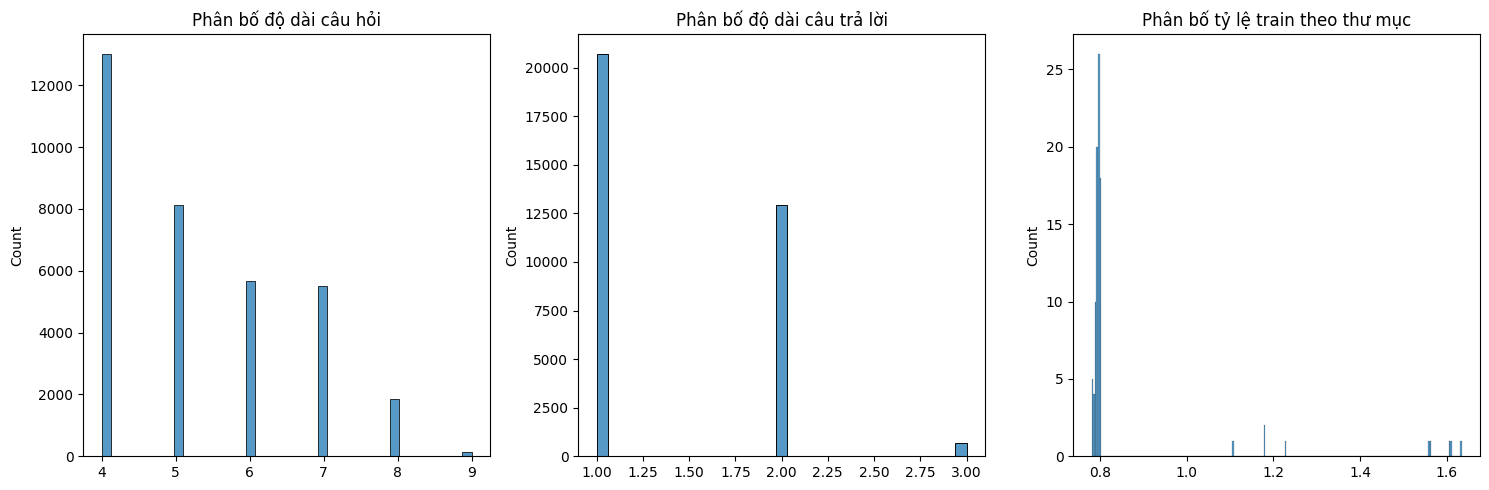

In [5]:
# Lưu metadata với thông tin chi tiết về phân chia
metadata = {
    "dataset_info": {
        "total_images": len(data),
        "total_questions": len(questions),
        "splits": {
            "train": {"size": len(train_data)},
            "val": {"size": len(val_data)},
            "test": {"size": len(test_data)}
        }
    },
    "directory_split_info": {},  # Sẽ được điền bên dưới
    "vocabulary": {
        "word_to_idx": text_processor.token_to_idx,
        "idx_to_word": text_processor.idx_to_token
    },
    "max_lengths": {
        "question": max(len(q.split()) for q in questions),
        "answer": max(len(a.split()) for a in answers)
    },
    "processing_info": {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "version": "1.0"
    }
}

# Thêm thông tin chi tiết về phân chia cho mỗi thư mục
for fruit_dir in fruit_dirs:
    dir_data = [item for item in data if item['image_id'].startswith(fruit_dir)]
    dir_train = [item for item in train_data if item['image_id'].startswith(fruit_dir)]
    dir_val = [item for item in val_data if item['image_id'].startswith(fruit_dir)]
    dir_test = [item for item in test_data if item['image_id'].startswith(fruit_dir)]
    
    metadata["directory_split_info"][fruit_dir] = {
        "total": len(dir_data),
        "train": len(dir_train),
        "val": len(dir_val),
        "test": len(dir_test)
    }

with open(os.path.join(PROCESSED_DIR, 'text', 'metadata.json'), 'w', encoding='utf-8') as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

# In thống kê chi tiết
print("\nThống kê dữ liệu theo thư mục:")
print(f"Tổng số ảnh: {len(data)}")
print(f"Tổng số câu hỏi: {len(questions)}")
print(f"Kích thước vocabulary: {len(text_processor)}")

print("\nPhân bố theo thư mục:")
for fruit_dir in fruit_dirs:
    dir_data = [item for item in data if item['image_id'].startswith(fruit_dir)]
    dir_train = [item for item in train_data if item['image_id'].startswith(fruit_dir)]
    dir_val = [item for item in val_data if item['image_id'].startswith(fruit_dir)]
    dir_test = [item for item in test_data if item['image_id'].startswith(fruit_dir)]
    
    print(f"\n{fruit_dir}:")
    print(f"- Tổng số: {len(dir_data)}")
    print(f"- Train: {len(dir_train)} ({len(dir_train)/len(dir_data)*100:.1f}%)")
    print(f"- Val: {len(dir_val)} ({len(dir_val)/len(dir_data)*100:.1f}%)")
    print(f"- Test: {len(dir_test)} ({len(dir_test)/len(dir_data)*100:.1f}%)")

# Vẽ biểu đồ phân bố
plt.figure(figsize=(15, 5))

# Phân bố độ dài câu hỏi
plt.subplot(1, 3, 1)
sns.histplot([len(q.split()) for q in questions])
plt.title('Phân bố độ dài câu hỏi')

# Phân bố độ dài câu trả lời
plt.subplot(1, 3, 2)
sns.histplot([len(a.split()) for a in answers])
plt.title('Phân bố độ dài câu trả lời')

# Phân bố tỷ lệ train/val/test theo thư mục
plt.subplot(1, 3, 3)
ratios = []
for fruit_dir in fruit_dirs:
    dir_data = [item for item in data if item['image_id'].startswith(fruit_dir)]
    dir_train = [item for item in train_data if item['image_id'].startswith(fruit_dir)]
    ratios.append(len(dir_train)/len(dir_data))
sns.histplot(ratios)
plt.title('Phân bố tỷ lệ train theo thư mục')

plt.tight_layout()
plt.show()

In [6]:
# Load và kiểm tra dữ liệu đã xử lý
def load_processed_data(split='train'):
    # Load ảnh
    images = np.load(os.path.join(PROCESSED_DIR, 'images', f'{split}.npz'))['images']
    images = torch.from_numpy(images).float()
    
    # Load text
    questions = np.load(os.path.join(PROCESSED_DIR, 'text', f'{split}_questions.npz'))['questions']
    questions = torch.from_numpy(questions).long()
    answers = np.load(os.path.join(PROCESSED_DIR, 'text', f'{split}_answers.npz'))['answers']
    answers = torch.from_numpy(answers).long()
    
    # Load metadata
    with open(os.path.join(PROCESSED_DIR, 'text', 'metadata.json'), 'r', encoding='utf-8') as f:
        metadata = json.load(f)
    
    return images, questions, answers, metadata

# Kiểm tra dữ liệu train
images, questions, answers, metadata = load_processed_data('train')

print("\nKiểm tra dữ liệu đã xử lý:")
print(f"Kích thước ảnh: {images.shape}")
print(f"Kích thước câu hỏi: {questions.shape}")
print(f"Kích thước câu trả lời: {answers.shape}")

# In một số ví dụ
print("\nVí dụ câu hỏi và câu trả lời:")
for i in range(3):
    print(f"\nVí dụ {i+1}:")
    print("Câu hỏi:", text_processor.decode(questions[0][i].tolist()))
    print("Câu trả lời:", text_processor.decode(answers[0][i].tolist()))


Kiểm tra dữ liệu đã xử lý:
Kích thước ảnh: torch.Size([7284, 3, 224, 224])
Kích thước câu hỏi: torch.Size([7284, 4, 10])
Kích thước câu trả lời: torch.Size([7284, 4, 5])

Ví dụ câu hỏi và câu trả lời:

Ví dụ 1:
Câu hỏi: ['<SOS>', 'đây', 'là', 'quả', 'gì', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Câu trả lời: ['<SOS>', 'hạnh nhân', '<EOS>', '<PAD>', '<PAD>']

Ví dụ 2:
Câu hỏi: ['<SOS>', 'số', 'lượng', 'hạnh nhân', 'là', 'bao', 'nhiêu', '<EOS>', '<PAD>', '<PAD>']
Câu trả lời: ['<SOS>', 'không', 'rõ', '<EOS>', '<PAD>']

Ví dụ 3:
Câu hỏi: ['<SOS>', 'màu', 'sắc', 'của', 'hạnh nhân', 'là', 'gì', '<EOS>', '<PAD>', '<PAD>']
Câu trả lời: ['<SOS>', 'nâu', '<EOS>', '<PAD>', '<PAD>']
